In [71]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from scipy.stats import ttest_1samp

# Processing data

In [43]:
rca = pd.read_csv('../../data/final/rca_ensemb.csv').query('check == "pass"')
rca

,embed,norm,train_n,fold,r2,check
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,pass
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,pass
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,pass
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,pass
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,pass
...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,pass
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,pass
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,pass
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,pass


In [44]:
# Changing category names to custom cat names
meta = pd.read_csv('../../data/raw/psychNorms_metadata.csv', index_col=0)
meta

,description,citation,category,associated_embed,type,n_ratings
norm,,,,,,
Freq_HAL,Log10 version of frequency norms based on the ...,"Lund, K. and C. Burgess (1996). ""Producing hig...",frequency,NaN,continuous,79671
Freq_KF,Log10 version of frequency norms based on the ...,"Kučera, H. and W. N. Francis (1967). Computati...",frequency,NaN,continuous,35230
Freq_SUBTLEXUS,Log10 version of frequency norms based on the ...,"Brysbaert, M. and B. New (2009). ""Moving beyon...",frequency,NaN,continuous,57214
Freq_SUBTLEXUK,Log10 version of the frequency norms based on ...,"Van Heuven, W. J., et al. (2014). ""SUBTLEX-UK:...",frequency,NaN,continuous,61843
Freq_Blog,Log10 version of the frequency norms based on ...,"Gimenes, M. and B. New (2016). ""Worldlex: Twit...",frequency,NaN,continuous,70646
...,...,...,...,...,...,...
familiarity_vanarsdall,Ratings from 1 (highly unfamiliar) to 7 (highl...,"@article{vanarsdall2022analyzing,\n title={An...",familiarity,NaN,continuous,1200
imageability_vanarsdall,Ratings from 1 (low imagery) to 7 (high imagery),"@article{vanarsdall2022analyzing,\n title={An...",imageability,NaN,continuous,1200
familiarity_fear,Ratings from 1 (extremely infrequent) to 7 (ex...,"@article{fear1997ratings,\n title={Ratings fo...",familiarity,NaN,continuous,703


In [45]:
# Adding norm_category to rca
rca['norm_category'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca

,embed,norm,train_n,fold,r2,check,norm_category
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,pass,frequency
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,pass,frequency
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,pass,frequency
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,pass,frequency
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,pass,frequency
...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,pass,imageability
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,pass,imageability
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,pass,imageability
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,pass,imageability


In [46]:
rca_mean = (
    rca[['embed', 'norm', 'r2']].groupby(['embed', 'norm'], as_index=False).mean()
    .rename(columns={'r2': 'r2_mean'})
)
rca_mean

,embed,norm,r2_mean
0,CBOW_GoogleNews,Angry_Binder,0.529488
1,CBOW_GoogleNews,AoA_Glasgow,0.604935
2,CBOW_GoogleNews,AoA_Kuper,0.580193
3,CBOW_GoogleNews,AoA_LWV,0.610645
4,CBOW_GoogleNews,Arousal_Binder,0.553350
...,...,...,...
1450,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097
1451,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989
1452,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038
1453,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210


In [47]:
rca_mean['norm_category'] = (
    rca_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)
rca_mean

,embed,norm,r2_mean,norm_category
0,CBOW_GoogleNews,Angry_Binder,0.529488,emotion
1,CBOW_GoogleNews,AoA_Glasgow,0.604935,age of acquisition
2,CBOW_GoogleNews,AoA_Kuper,0.580193,age of acquisition
3,CBOW_GoogleNews,AoA_LWV,0.610645,age of acquisition
4,CBOW_GoogleNews,Arousal_Binder,0.553350,arousal
...,...,...,...,...
1450,morphoNLM&PPMI_SVD_SWOW,valence_janschewitz,0.700097,valence
1451,morphoNLM&PPMI_SVD_SWOW,valence_zupan,0.790989,valence
1452,morphoNLM&PPMI_SVD_SWOW,visual_complexity_marrow,0.524038,sensory
1453,morphoNLM&PPMI_SVD_SWOW,visual_lyn,0.489210,sensory


In [48]:
rca_grand_mean = (
    rca_mean[['embed', 'norm_category', 'r2_mean']]
    .groupby(['embed', 'norm_category'], as_index=False).mean(numeric_only=True)
    .rename(columns={'r2_mean': 'r2_grand_mean'})
)
rca_grand_mean

,embed,norm_category,r2_grand_mean
0,CBOW_GoogleNews,age of acquisition,0.413873
1,CBOW_GoogleNews,animacy,0.720898
2,CBOW_GoogleNews,arousal,0.528839
3,CBOW_GoogleNews,associatability,0.146539
4,CBOW_GoogleNews,autidtory lexical decision,0.076410
...,...,...,...
130,morphoNLM&PPMI_SVD_SWOW,social/moral,0.674280
131,morphoNLM&PPMI_SVD_SWOW,space/time/quantity,0.485689
132,morphoNLM&PPMI_SVD_SWOW,this/that,0.516101
133,morphoNLM&PPMI_SVD_SWOW,valence,0.718647


In [49]:
with open('../../data/raw/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
def embed_to_group(embed_name):
    if '&' in embed_name:
        name_1, name_2 = embed_name.split('&')
        return embed_to_type[name_1] + '&' + embed_to_type[name_2]
    else:
        return embed_to_type[embed_name]
    
rca_grand_mean['embed'] = rca_grand_mean['embed'].apply(embed_to_group)
rca_grand_mean = rca_grand_mean.groupby(['embed', 'norm_category'], as_index=False).mean(numeric_only=True)
rca_grand_mean['norm_category'] = rca_grand_mean['norm_category'].str.title()
rca_grand_mean

,embed,norm_category,r2_grand_mean
0,text,Age Of Acquisition,0.361621
1,text,Animacy,0.615593
2,text,Arousal,0.401580
3,text,Associatability,0.176012
4,text,Autidtory Lexical Decision,0.073087
...,...,...,...
76,text&text,Social/Moral,0.632243
77,text&text,Space/Time/Quantity,0.499539
78,text&text,This/That,0.525242
79,text&text,Valence,0.636918


In [50]:
# Sorts norm_category by grand mean of top_embed 
categories = (
    rca_grand_mean.query(f'embed == "text&behavior"')
    .sort_values('r2_grand_mean', ascending=True)['norm_category']
)
rca_grand_mean['norm_category'] = pd.Categorical(
    rca_grand_mean['norm_category'], categories=categories, ordered=True
)
rca_grand_mean = (
    rca_grand_mean.sort_values('norm_category', ascending=False).reset_index(drop=True)
)
rca_grand_mean

,embed,norm_category,r2_grand_mean
0,text&text,Valence,0.636918
1,text&behavior,Valence,0.729151
2,text,Valence,0.465377
3,text,Animacy,0.615593
4,text&text,Animacy,0.727980
...,...,...,...
76,text,Semantic Decision,0.090438
77,text&behavior,Semantic Decision,0.081558
78,text&behavior,Autidtory Lexical Decision,0.076965
79,text&text,Autidtory Lexical Decision,0.095321


In [51]:
# Top embed_types
sorted_embeds = (
    rca_grand_mean.groupby('embed')['r2_grand_mean']
    .agg(['mean', 'std'])
    .sort_values('mean', ascending=True)
    .reset_index()
)
sorted_embeds

,embed,mean,std
0,text,0.349740,0.161515
1,text&text,0.445629,0.194034
2,text&behavior,0.451493,0.213082


## Plotting 

In [52]:
# Colors 
cmap = plt.get_cmap('viridis', 4)
embed_to_color = {
    'text&text': cmap(4),
    'text&behavior': cmap(0),
    'text': cmap(2)
}
{key: mcolors.to_hex(value) for key, value in embed_to_color.items()}

{'text&text': '#fde725', 'text&behavior': '#440154', 'text': '#35b779'}

/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_8401/2296488418.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set(xlabel='', xticklabels=['Text', 'Text & Text', 'Text & Behavior'])


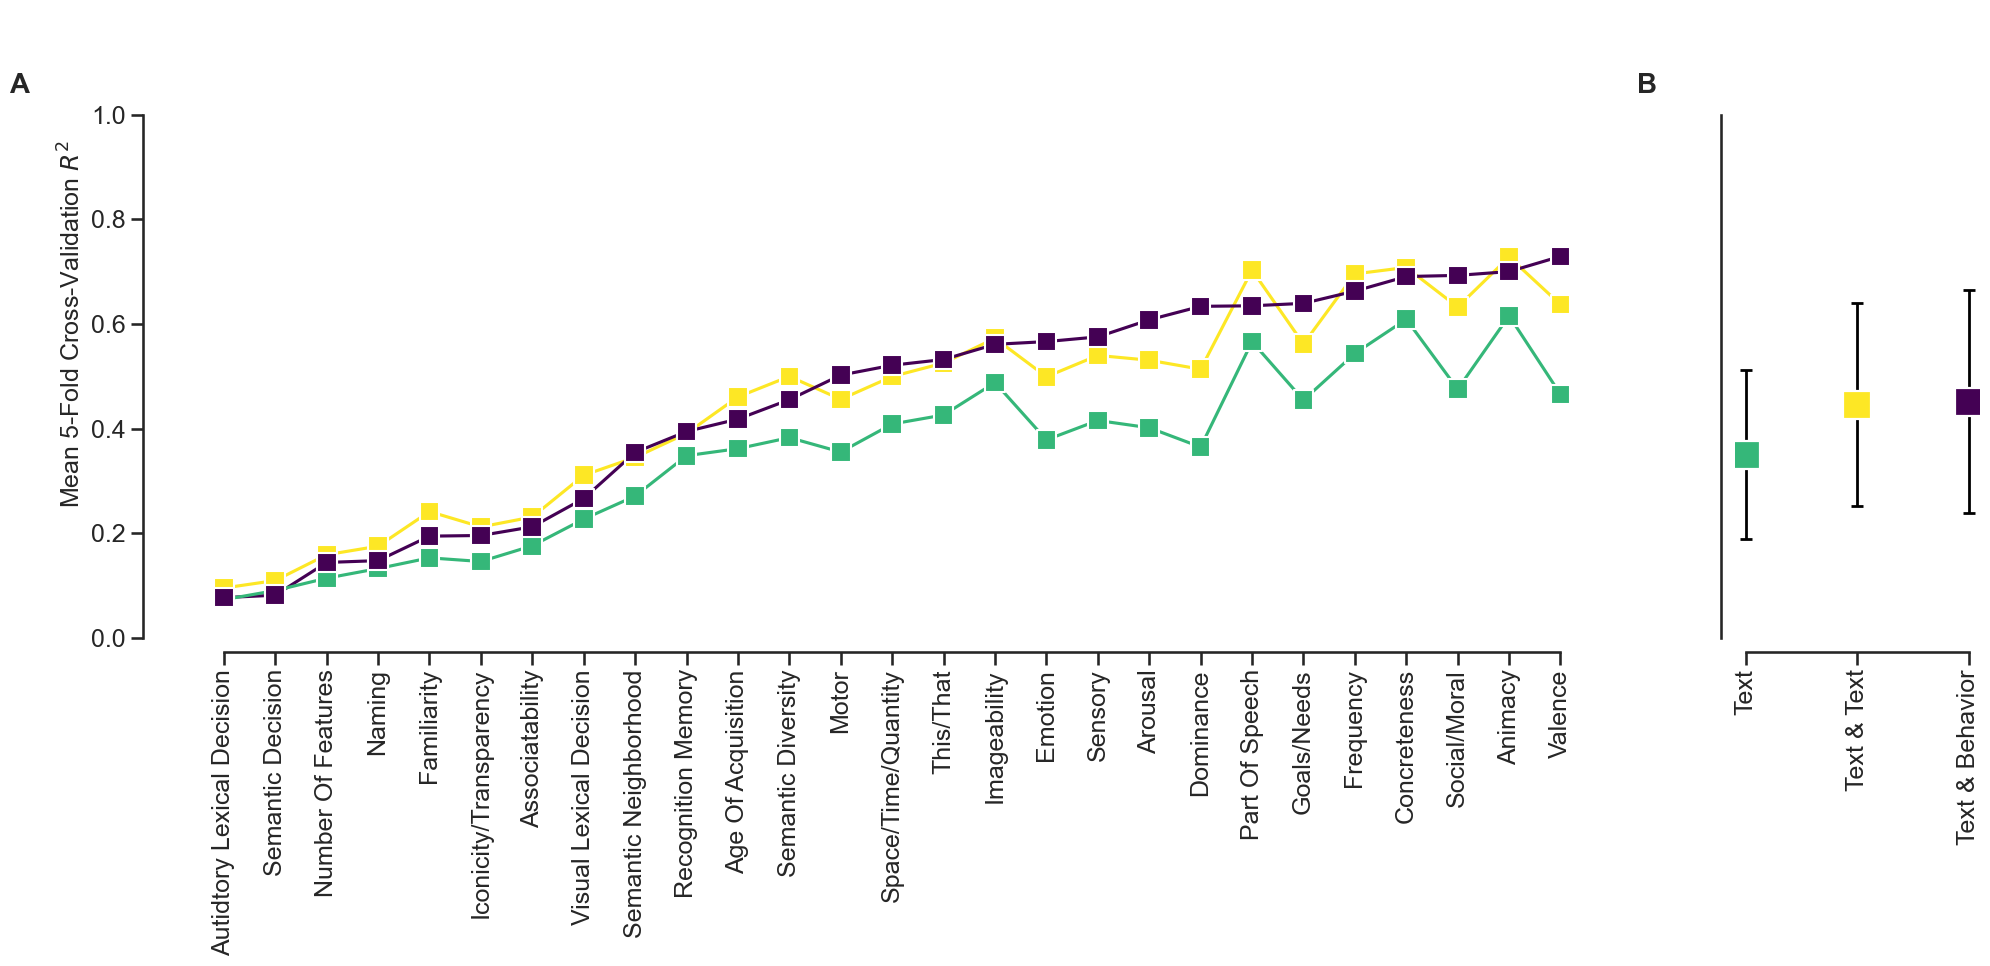

In [53]:
sns.set(context='talk', style='white')
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(20, 10), width_ratios=[6, 1], sharey=True)

# ax_1
sns.lineplot(
    rca_grand_mean,
    x='norm_category', y='r2_grand_mean', hue='embed',
    palette=embed_to_color, zorder=0, legend=False, 
    ax=ax_1
)

for i, embed in enumerate(['text', 'text&text', 'text&behavior']):
    sns.scatterplot(
        rca_grand_mean.query(f'embed == "{embed}"'), 
        marker='s', x='norm_category', y='r2_grand_mean', hue='embed',
        s=200, palette=embed_to_color, edgecolor='white', linewidth=1.5,
        zorder=i+1, legend=False,
        ax=ax_1
    )
    
# ax_2
sns.scatterplot(
    sorted_embeds,
    x='embed', y='mean', hue='embed',
    palette=embed_to_color, legend=False,
    marker='s', s=400, edgecolor='white',
    zorder=1, 
    ax=ax_2
)

thickness = 2
ax_2.errorbar(
    x=[0, 1, 2], y=sorted_embeds['mean'], yerr=sorted_embeds['std'],
    fmt='none', ecolor='black', lw=thickness, capsize=4, capthick=thickness, zorder=0
)

    
# Formatting axes
y_min, y_max = 0, 1.2
ax_1.set(
    ylim=(y_min, y_max), xlabel='', ylabel='Mean 5-Fold Cross-Validation $R^2$',
    yticks=np.arange(y_min, y_max, .2)
)
ax_2.set(xlabel='', xticklabels=['Text', 'Text & Text', 'Text & Behavior'])

for ax in [ax_1, ax_2]:
    ax.tick_params(axis='x', rotation=90, which='both', bottom=True, top=False, labelbottom=True, labelsize=18)
    
ax_1.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=18)

# Adding bold panel labels
h = .9
ax_1.text(-0.1, h, 'A', transform=ax_1.transAxes, fontsize=20, fontweight='bold', va='top')
ax_2.text(-0.4, h, 'B', transform=ax_2.transAxes, fontsize=20, fontweight='bold', va='top')


sns.despine(offset=10, trim=True)
fig.tight_layout()
fig.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

## Paper Stats

In [54]:
# rca['embed'] = rca['embed'].apply(embed_to_group)
rca

,embed,norm,train_n,fold,r2,check,norm_category
0,CBOW_GoogleNews,Freq_HAL,8668,1,0.660651,pass,frequency
1,CBOW_GoogleNews,Freq_HAL,8668,2,0.659874,pass,frequency
2,CBOW_GoogleNews,Freq_HAL,8668,3,0.678498,pass,frequency
3,CBOW_GoogleNews,Freq_HAL,8668,4,0.657754,pass,frequency
4,CBOW_GoogleNews,Freq_HAL,8668,5,0.687100,pass,frequency
...,...,...,...,...,...,...,...
7295,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,1,0.512233,pass,imageability
7296,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,2,0.586266,pass,imageability
7297,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,3,0.555577,pass,imageability
7298,morphoNLM&PPMI_SVD_SWOW,imageability_fear,500,4,0.437230,pass,imageability


In [64]:
# Pivoting 
rca_piv = ( 
    rca[['embed', 'norm', 'norm_category', 'fold', 'r2']]
    .pivot(index=['norm', 'fold', 'norm_category'], columns='embed', values='r2')
    .reset_index()
)
rca_piv

embed,norm,fold,norm_category,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&morphoNLM,morphoNLM,morphoNLM&PPMI_SVD_SWOW
0,Angry_Binder,1,emotion,0.451075,0.617672,0.477270,0.497775,0.628661
1,Angry_Binder,2,emotion,0.665392,0.697556,0.660971,0.456568,0.697498
2,Angry_Binder,3,emotion,0.612515,0.637159,0.617868,0.423920,0.653719
3,Angry_Binder,4,emotion,0.546103,0.611599,0.545594,0.225442,0.564086
4,Angry_Binder,5,emotion,0.372354,0.598570,0.434177,0.390407,0.630914
...,...,...,...,...,...,...,...,...
1450,visual_troche,1,sensory,0.774042,0.813851,0.814768,0.692471,0.721595
1451,visual_troche,2,sensory,0.766725,0.726652,0.798349,0.645648,0.651587
1452,visual_troche,3,sensory,0.728824,0.722114,0.720193,0.628234,0.679291
1453,visual_troche,4,sensory,0.806846,0.798616,0.791059,0.645656,0.689450


In [82]:
def diff_stats(norm_cat):
    norm_dat = rca_piv.query(f'norm_category == "{norm_cat}"')
    diffs = pd.concat([
        norm_dat['morphoNLM&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
        norm_dat['CBOW_GoogleNews&PPMI_SVD_SWOW'] - norm_dat['CBOW_GoogleNews&morphoNLM'],
    ])
    t, p = ttest_1samp(diffs, 0)
    return {'mean': diffs.mean().round(2), 't': round(t, 2), 'p': p}

# Text & Behavior > Text & Text
print(diff_stats('valence'))
print(diff_stats('social/moral'))
print(diff_stats('goals/needs'))
print(diff_stats('dominance'))
print(diff_stats('arousal'))
print(diff_stats('emotion'))

# Text & Behavior < Text & Text
print(diff_stats('part of speech'))
print(diff_stats('semantic diversity'))
print(diff_stats('familiarity'))

{'mean': 0.09, 't': 25.27, 'p': 6.139943003330122e-61}
{'mean': 0.06, 't': 12.13, 'p': 2.1635908003177562e-24}
{'mean': 0.08, 't': 6.65, 'p': 2.7378322855386877e-07}
{'mean': 0.12, 't': 20.88, 'p': 5.079343793695236e-19}
{'mean': 0.08, 't': 13.05, 'p': 2.2502625980251323e-22}
{'mean': 0.07, 't': 19.89, 'p': 2.8559467618000574e-57}
{'mean': -0.07, 't': -6.91, 'p': 1.3673122819058808e-06}
{'mean': -0.04, 't': -11.0, 'p': 2.2544026551851517e-19}
{'mean': -0.05, 't': -5.79, 'p': 2.413028449008883e-08}


In [70]:
valence = rca_piv.query('norm_category == "valence"')
valence_diffs = pd.concat([
    valence['morphoNLM&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
    valence['CBOW_GoogleNews&PPMI_SVD_SWOW'] - valence['CBOW_GoogleNews&morphoNLM'],
])

# scipy t-test for valence


ttest_1samp(valence_diffs, 0)

TtestResult(statistic=25.269566284921364, pvalue=6.139943003330122e-61, df=179)